In [73]:
import sys
sys.path.append('wgs_tools/')
import numpy as np
import glob
import os
from IPython.display import Image
import re
import tqdm
import multiprocessing
import pandas as pd
from shutil import copyfile
from mpl_toolkits.mplot3d import Axes3D
import json
import ast 
import random
from scipy import stats
from numba import jit
import pickle as pkl
import datetime
import matplotlib
import seaborn as sns;
import matplotlib.pylab as plt
import wgs_compare
import wgs_analyse
%matplotlib notebook
sns.set()

# Get off-target sites using CasOFFinder (up to 4 mismatches and 1 bulge)

In [2]:
refgene_path = "/srv/local/jason/genome.fa"
gRNA_name = 'HEK4'
gRNA_seq = "GGCACTGCGGCTGGAGGTGG" # HEK4
n_mismatches = 4
n_dna_bulges = 1
n_rna_bulges = 1

In [3]:
def build_casOffinder_input(refgene_path, gRNA_seq, n_mismatches, n_dna_bulges, n_rna_bulges):
    s = refgene_path + "\n" # Referenece Genome
    s += "N"*len(gRNA_seq) + "NNN " + str(n_dna_bulges) + " " + str(n_rna_bulges) + "\n" # PAM type + #DNA bulge + #RNA bulge
    s += gRNA_seq + "NNN " + str(n_mismatches) + "\n"
    return s

In [4]:
with open("./HEK4_test/" + gRNA_name + "_casOffinder_input.txt", "w") as f:
    f.write(build_casOffinder_input(refgene_path, gRNA_seq, n_mismatches, n_dna_bulges, n_rna_bulges))

In [5]:
! cat ./HEK4_test/HEK4_casOffinder_input.txt

/srv/local/jason/genome.fa
NNNNNNNNNNNNNNNNNNNNNNN 1 1
GGCACTGCGGCTGGAGGTGGNNN 4


In [15]:
pwd

'/srv/local/jason/wgs_analysis_nb'

## Run Cas-OFFinder-bulge

In [18]:
! ./cas-offinder-bulge ../../HEK4_test/HEK4_casOffinder_input.txt G ../../HEK4_test/HEK4.GGCACTGCGGCTGGAGGTGG.gap1.offby4.NNN.CasOffinder.out # use GPU

Created temporary file (../../HEK4_test/HEK4_casOffinder_input_bulge.txt).
Running Cas-OFFinder (output file: ../../HEK4_test/HEK4_casOffinder_input_bulgeout.txt)...
Total 2 device(s) found.
Loading input file...
Reading /srv/local/jason/genome.fa...
Sending data to devices...
Chunk load started.
2 devices selected to analyze...
Finding pattern in chunk #1...
Comparing patterns in chunk #1...
2 devices selected to analyze...
Finding pattern in chunk #2...
Comparing patterns in chunk #2...
2 devices selected to analyze...
Finding pattern in chunk #3...
Comparing patterns in chunk #3...
2 devices selected to analyze...
Finding pattern in chunk #4...
Comparing patterns in chunk #4...
2 devices selected to analyze...
Finding pattern in chunk #5...
Comparing patterns in chunk #5...
2 devices selected to analyze...
Finding pattern in chunk #6...
Comparing patterns in chunk #6...
2 devices selected to analyze...
Finding pattern in chunk #7...
Comparing patterns in chunk #7...
1 devices select

# Make amplicon around putative off-targets (84bp)

In [22]:
!perl ./wgs_tools/makeAmplicons.pl 42 ./HEK4_test/HEK4.GGCACTGCGGCTGGAGGTGG.gap1.offby4.NNN.CasOffinder.out # pad 42bp around cutsites 

Running with parameters:
padding: 42
casoffinderFile: ./HEK4_test/HEK4.GGCACTGCGGCTGGAGGTGG.gap1.offby4.NNN.CasOffinder.out
outputFile: ./HEK4_test/HEK4.GGCACTGCGGCTGGAGGTGG.gap1.offby4.NNN.CasOffinder.out.pad42.txt
cleavageOffset: -3
Finished. Printed 338826 to ./HEK4_test/HEK4.GGCACTGCGGCTGGAGGTGG.gap1.offby4.NNN.CasOffinder.out.pad42.txt


In [23]:
!head ./HEK4_test/HEK4.GGCACTGCGGCTGGAGGTGG.gap1.offby4.NNN.CasOffinder.out.pad42.txt

Chromosome	-45	40	#Bulge typeBulge SizeMismatches_0		
chr1	964023	964108	DNA14_1	GGCACTcCtGCTGGGAGtgGG	
chr1	1019512	1019597	DNA14_2	GGagCTGCGGCgCGGAGGcGG	
chr1	1170037	1170122	DNA14_3	GGCACaGCGGtgAGGAGGTGc	
chr1	1151396	1151481	DNA14_4	GGCACTcCtGCTGGGtGGgGG	
chr1	1255705	1255790	DNA14_5	GGCACaGCGGCTGccAtGTGG	
chr1	1274297	1274382	DNA14_6	GGtgCTGCGGCgCGGAcGTGG	
chr1	1441125	1441210	DNA14_7	GGaACTGCaGCaTtGAGGTGG	
chr1	2130434	2130519	DNA14_8	GGCACaGgGtCTCcGAGGTGG	
chr1	2198996	2199081	DNA14_9	GcCACTGaGGCTGtGAGGaGG	


# Run CRISPRessoWGS on HEK4 off sites

In [24]:
HEK4_bam_file = "/srv/local/jason/HEK4_WGS/HEKSite4.bam"
DNMT1_bam_file = "/srv/local/jason/DNMT1_WGS/DNMT1Site3.bam"  # Control
offs_file = "./HEK4_test/HEK4.GGCACTGCGGCTGGAGGTGG.gap1.offby4.NNN.CasOffinder.out.pad42.txt"

## CRISPRessoWGS on HEK4

/data/pinello/SHARED_SOFTWARE/anaconda3/envs/crispresso2/bin/CRISPRessoWGS -f /srv/local/jason/HEK4_WGS/HEK4.GGCACTGCGGCTGGAGGTGG.gap1.offby4.NNN.CasOffinder.out.pad42.txt -b /srv/local/jason/HEK4_WGS/HEKSite4.bam -r /srv/local/jason/genome.fa -p 30 --plot_window_size 40 --no_rerun --exclude_bp_from_right 0 --exclude_bp_from_left 0 --skip_failed --suppress_plots --suppress_report --discard_guide_positions_overhanging_amplicon_edge

## CRISPRessoWGS on DNMT1

/data/pinello/SHARED_SOFTWARE/anaconda3/envs/crispresso2/bin/CRISPRessoWGS -f /srv/local/jason/HEK4_WGS/HEK4.GGCACTGCGGCTGGAGGTGG.gap1.offby4.NNN.CasOffinder.out.pad42.txt -b /srv/local/jason/DNMT1_WGS/DNMT1Site3.bam -r /srv/local/jason/genome.fa -p 30 --plot_window_size 40 --no_rerun --exclude_bp_from_right 0 --exclude_bp_from_left 0 --skip_failed --suppress_plots --suppress_report --discard_guide_positions_overhanging_amplicon_edge

# Extract alleles from CRISPRessoWGS output

In [89]:
HEK4_crispressoWGS_path = "/srv/local/jason/HEK4_WGS/CRISPRessoWGS_on_HEK4_4mm1gap/"
DNMT1_crispressoWGS_path = "/srv/local/jason/HEK4_WGS/CRISPRessoWGS_on_DNMT1HEK4_4mm1gap/"

In [90]:
HEK4_4mm_info = pkl.load(open(HEK4_crispressoWGS_path + "/CRISPResso2WGS_info.pickle", "rb"), encoding='latin1')
all_regions = HEK4_4mm_info['all_region_read_counts']
good_regions = HEK4_4mm_info['good_region_folders']
HEK4_df = HEK4_4mm_info['regions']

In [91]:
DNMT1HEK4_4mm_info = pkl.load(open(HEK4_crispressoWGS_path + "/CRISPResso2WGS_info.pickle", "rb"), encoding='latin1')
DNMT1HEK4_all_regions = HEK4_4mm_info['all_region_read_counts']
DNMT1HEK4_good_regions = HEK4_4mm_info['good_region_folders']
DNMT1HEK4_df = DNMT1HEK4_4mm_info['regions']

In [96]:
HEK4_df['target_seq'] = None
HEK4_df['Good_region'] = False
HEK4_df['loc_info'] = None
def get_trim_refSeq(folder):
    # allele_tables = glob.glob(folder + "/Alleles_frequency_table_around_sgRNA*txt")
    info = pkl.load(open(folder + "/CRISPResso2_info.pickle", "rb"), encoding='latin1')
    res_info = info['refs']['Reference']
    # cutsite = res_info['gRNA_cut_points'][0]
    whole_seq = res_info['sequence']
    idxs = res_info['sgRNA_plot_idxs'][0]
    allele_txt = res_info['allele_frequency_files'][0]
    refseq_80b = whole_seq[idxs[0]:idxs[-1]+1]
    return refseq_80b

def label_offsite(good_region):
    HEK4_wgs_path = "/srv/local/jason/HEK4_WGS/CRISPRessoWGS_on_HEK4_4mm1gap/"
    name, folder = good_region
    path = HEK4_wgs_path + folder
    ref_seq = get_trim_refSeq(path)
    site_info = HEK4_df.loc[name]
    # HEK4_df.loc[name, 'Good_region'] = True
    loc_info = site_info['chr_id'] + ":" + str(site_info['bpstart']) + "-" +  str(site_info['bpend']) + "_" + str(site_info['n_reads'])
    return [name, ref_seq, True, loc_info]

results = []
for gr in tqdm.tqdm(good_regions.items()):
    try:
        results.append(label_offsite(gr))
    except Exception as e:
        print(gr, e)

100%|██████████| 336219/336219 [05:55<00:00, 945.79it/s] 


In [99]:
results = np.array(results)
HEK4_df.loc[results[:,0], 'target_seq'] = results[:,1]
HEK4_df.loc[results[:,0], 'Good_region'] = results[:,2]
HEK4_df.loc[results[:,0], 'loc_info'] = results[:,3]
HEK4_df.to_csv("./HEK4/HEK4.4mm.1gap.region.info.tsv", "\t", index_label='target_name')

In [102]:
HEK4_good = HEK4_df[HEK4_df['Good_region'] == 'True']
HEK4_good = HEK4_good[['chr_id','bpstart','bpend', 'target_seq', 'n_reads', 'loc_info']]
HEK4_good[HEK4_good['chr_id'] != 'chrY'].to_csv("./HEK4.4mm.1gap.GOOD.targetsite.csv", index_label = 'target_name')

In [104]:
HEK4_good = pd.read_csv("./HEK4_test//HEK4.4mm.1gap.GOOD.targetsite.csv", index_col='target_name')

###  Alleles at putative off-target sites from CRISPRessoWGS

In [105]:
HEK4_good

,chr_id,bpstart,bpend,target_seq,n_reads,loc_info
target_name,,,,,,
X04_1,chr1,15346,15431,AAGCTCAAAACCATAGTGCCCAGGGCACTGCCGCTGCAGGCGCAGG...,1293,chr1:15346-15431_1293
X04_2,chr1,185867,185952,AAGCTCAAAACCATAGTGCCCAGGGCACTGCCGCTGCAGGCGCAGG...,1191,chr1:185867-185952_1191
X04_3,chr1,402683,402768,GGCTGGCACTGAGTCTGGGGAAGGGAGCTGGGGCTGGAGGTGTGGA...,519,chr1:402683-402768_519
X04_4,chr1,638436,638521,GGCTGGCACTGAGTCTGGGGAAGGGAGCTGGGGCTGGAGGTGTGGA...,588,chr1:638436-638521_588
X04_5,chr1,902128,902213,CATGCTAGACCCTGGGTGGAGAGAGCGAGGCGGCTGGAGGTGGGTG...,754,chr1:902128-902213_754
...,...,...,...,...,...,...
RNA14_357447,chrX,154640341,154640426,TGTGACCTCCCGCGGCGCAGCACCTGCCCTCCCCACCCACCTCCTC...,820,chrX:154640341-154640426_820
RNA14_357448,chrX,154751225,154751310,GCAGCGAAGCCTGGGAAGCCCCTTCGAGCAACTGCAGCTCCGCCAG...,506,chrX:154751225-154751310_506
RNA14_357449,chrX,155577724,155577809,TAGGTTGGTGCAAAAGTAATTGCAGTTTTTGCCTTAACACATCCAG...,615,chrX:155577724-155577809_615


In [107]:
HEK4_good = HEK4_good.drop_duplicates('loc_info', 'first') # drop duplicated locus
HEK4_good.to_csv("./HEK4.4mm.1gap.GOOD.dedup.targetsite.csv", index_label='target_name')

# Predict alleles using InDelphi (Max W. Shen et al, Nature, 2018)

In [ ]:
import sys
import pandas as pd
sys.path.extend("./wgs_tools/inDelphi")
import os
import re
from multiprocessing.dummy import Pool as ThreadPool 
# ct = 'U2OS'
class indelphi_score:
    def __init__(self, trg_name, trg_seq, cutsite=40, dirpath="./"):
        self.trg_name = trg_name
        self.trg_seq = trg_seq
        self.cutsite = cutsite
        self.dirpath = dirpath
    
    def get_indelphi_score(self):
        import inDelphi
        inDelphi.init_model()
        try:
            pred_df, stats = inDelphi.predict(self.trg_seq, self.cutsite)
            pred_df = inDelphi.add_mhless_genotypes(pred_df, stats)
            pred_df = inDelphi.add_genotype_column(pred_df, stats)
            pred_df = inDelphi.add_name_column(pred_df, stats)
            pred_df.to_csv(self.dirpath + self.trg_name + ".csv", index=False)
        except:
            print(self.trg_name, "error")

foldpath = "./HEK4_WGS/CRISPRessoWGS.HEK4.4mm1gap.indelphi/"
if not os.path.exists(foldpath):
    os.mkdir(foldpath)
    
df = pd.read_csv("./HEK4_test/HEK4.4mm.1gap.GOOD.dedup.targetsite.csv")
names, seqs = list(df['target_name'])[:1000], list(df['target_seq'])[:1000]

def buildIndelphiScoreFile(inputs):
    trgName, trgSeq = inputs
    path = foldpath
    if os.path.getsize(path + trgName + ".csv") > 10:
        return 0
    idp = indelphi_score(trgName, trgSeq, dirpath = path)
    idp.get_indelphi_score()
    with open("./HEK4_test/log/indelphi.HEK4.4mm.1gap.dedup.log","a+") as f:
        print(trgName, file=f)

pool = ThreadPool(40)
inputs = list(zip(names,seqs))
res = pool.map(buildIndelphiScoreFile, inputs)
pool.close()
pool.join()

# Compare observed alleles from CRISPRessoWGS to predictive alleles with InDelphi

In [26]:
def get_wgs_stats_result(wgs_fns):
    possible_fn, reads_treated_fn, reads_control_fn = wgs_fns
    trg_name = re.split("/|.csv", possible_fn)[-2]
    wgs = wgs_analyse.stats_WGS_data(reads_treated_fn=reads_treated_fn, reads_control_fn=reads_control_fn, possible_fn=possible_fn)
    res_dict = {}
    try:
        res_dict = wgs.wgs_analysis()
        with open("./HEK4_test/log/stat_HEK4_4mm1gap_results_withPvalue.log", "a+") as f:
             print(trg_name, res_dict, file=f)
    except Exception as e:
        with open("./HEK4_test/log/stat_HEK4_4mm1gap_error_withPvalue.log", "a+") as f:
            print(trg_name, e, file=f)
    return (trg_name, res_dict)

In [53]:
def process_wgs_data(tn, tn_seq, collectReadsdf = True, processIndelphi=True, gen_possible_df=True, verbose=False):
    possible_df_folder = './HEK4_test/CRISPRessoWGS.HEK4.4mm1gap.possible/'
    treated_reads_df_folder = "./HEK4_test/CRISPRessoWGS.HEK4.4mm1gap.reads/"
    control_reads_df_folder = "./HEK4_test/CRISPRessoWGS.DNMT1HEK4.4mm1gap.reads/"
    indelphi_foler = "../HEK4_WGS/CRISPRessoWGS.HEK4.4mm1gap.indelphi/"
    
    possible_fn = possible_df_folder + tn + ".csv"
    reads_treated_fn = treated_reads_df_folder + tn + ".txt"
    reads_control_fn = control_reads_df_folder + tn + ".txt"
    indelphi_fn = indelphi_foler  + tn + ".csv"
    
    # possible_df_fold = "./CRISPRessoWGS.HEK4.4mm1gap.possible/"
    if not os.path.exists(possible_df_folder):
        os.mkdir(possible_df_folder)
        
    # treated_reads_df_fold = "./CRISPRessoWGS.HEK4.4mm1gap.reads/"
    if not os.path.exists(treated_reads_df_folder):
        os.mkdir(treated_reads_df_folder)
        
    # control_reads_df_fold = "./CRISPRessoWGS.DNMT1HEK4.4mm1gap.reads/"
    if not os.path.exists(control_reads_df_folder):
        os.mkdir(control_reads_df_folder)
                
    if verbose:print('target_name:', tn)
    
    if collectReadsdf:
        # pkl_file = open("./CRISPRessoWGS_on_RNF2/CRISPResso_on_"+tn+"/CRISPResso2_info.pickle",'rb')
        # Treatment
        tr_allele_tb = glob.glob("../HEK4_WGS/CRISPRessoWGS_on_HEK4_4mm1gap/CRISPResso_on_"+tn+"/Alleles_frequency_table_around_*txt")[0]
        des_path = treated_reads_df_folder + tn + ".txt"
        copyfile(tr_allele_tb, des_path)
        
        ct_allele_tb = glob.glob("../HEK4_WGS/CRISPRessoWGS_on_DNMT1HEK4_4mm1gap/CRISPResso_on_"+tn+"/Alleles_frequency_table_around_*txt")
        if len(ct_allele_tb) == 1:
            des_path = control_reads_df_folder + tn + ".txt"
            copyfile(ct_allele_tb[0], des_path)
        if verbose:print('1. Collecting Reads file from CRISPRessoWGS results finished!')
        
    if gen_possible_df:
    # generate possible repair outcome
        hlen = int(len(tn_seq)/2)
        left_seq = tn_seq[:hlen]
        right_seq = tn_seq[hlen:]
        del_limit = 59
        ins_limit = 1
        alleles = wgs_compare.get_outcomes(left_bit=left_seq, right_bit=right_seq, max_insertions=ins_limit, max_deletions=del_limit)
        # print(alleles)
        with open(possible_df_folder + "/" + tn +".csv", "w+") as f:
            for item in alleles:
                f.write("%s\n" %item)
        if verbose:print('2. Generated possible df finished!')
    else:
        if verbose:print('skip step 2 Generated possible df')
    
    # build_aligned_seq for indelphi_df
    analyser = wgs_analyse.WGS_analyser(indelphi_fn=indelphi_fn, ref_seq=tn_seq)
    analyser.build_aligned_seq_for_inDelphi()
    if verbose:print('3. build_aligned_seq for indelphi finished!')
    
    # mark allels idx in possible_df
    analyser = wgs_analyse.WGS_analyser(possible_fn=possible_fn)
    tn = analyser.mark_possible_gentype_idx()
    if verbose:print('4. mark allels idx in possible_df finished!')
    
    # build_no_mutated_aligned_seq for reads_df
    analyser = wgs_analyse.WGS_analyser(reads_fn=reads_treated_fn, ref_seq=tn_seq, reads_type='Treated')
    res = analyser.build_noMutated_aligned_seq_readfile()
    if os.path.exists(reads_control_fn):
        analyser = wgs_analyse.WGS_analyser(reads_fn=reads_control_fn, ref_seq=tn_seq, reads_type="Control")
        res = analyser.build_noMutated_aligned_seq_readfile()
    print('5. build_no_mutated_aligned_seq for reads_df finished!')
    # Map indelphi_df to possible_df
    analyser = wgs_analyse.WGS_analyser(indelphi_fn=indelphi_fn, possible_fn=possible_fn)
    analyser.map_indelphi_with_possible()
    if verbose:print("6. Map indelphi_df to possible_df finished!")

    # Map treated-control Reads_df to possible_df
    analyser = wgs_analyse.WGS_analyser(possible_fn=possible_fn, reads_fn=reads_treated_fn, reads_type="Treated")
    r1 = analyser.mapping_read_with_possible()
    analyser = wgs_analyse.WGS_analyser(possible_fn=possible_fn, reads_fn=reads_control_fn, reads_type='Control')
    r2 = analyser.mapping_read_with_possible()
    if verbose:print("7. Map treated-control Reads_df to possible_df finished!")
    if verbose:print("-------------------preprocessing finished---------------")
    with open("./HEK4_test/log/HEK4.4mm.1gap.WGSanlysis.log", "a+") as f:
         print(tn, "Treated:", r1, "Control", r2, file=f)
    return (tn, "Treated:", r1, "Control", r2)

### Compare observed alleles to predictive alleles on HEK4 on-target site

In [54]:
tname = 'X00_186759'
HEK4_df = pd.read_csv("./HEK4_test/HEK4.4mm.1gap.GOOD.dedup.targetsite.csv", index_col='target_name')
tn_seq = HEK4_df.loc[tname]['target_seq']
starttime = datetime.datetime.now()
process_wgs_data(tname, tn_seq, verbose=True)
endtime = datetime.datetime.now()
print("runing time", endtime - starttime)

target_name: X00_186759
1. Collecting Reads file from CRISPRessoWGS results finished!
2. Generated possible df finished!
3. build_aligned_seq for indelphi finished!
4. mark allels idx in possible_df finished!
5. build_no_mutated_aligned_seq for reads_df finished!
6. Map indelphi_df to possible_df finished!
7. Map treated-control Reads_df to possible_df finished!
-------------------preprocessing finished---------------
runing time 0:00:03.771385


In [55]:
pd.read_csv("./HEK4_test/CRISPRessoWGS.HEK4.4mm1gap.possible/X00_186759.csv")

,Category,Genotype position,Inserted Bases,Length,Microhomology length,Predicted frequency,Genotype,Name,Aligned_sequence,genotype_idx,match_idx_Treated,#Reads_total_Treated,match_idx_Control,#Reads_total_Control
0,del,0,NaN,1,NaN,1.375032,CAGGGGCACCGCGGCGCCCCGGTGGCACTGCGGCTGGAGGGGGGGT...,delT,CAGGGGCACCGCGGCGCCCCGGTGGCACTGCGGCTGGAGG-GGGGG...,1,2/32/,22,NaN,0
1,del,1,NaN,1,NaN,1.375032,CAGGGGCACCGCGGCGCCCCGGTGGCACTGCGGCTGGAGTGGGGGT...,delG,CAGGGGCACCGCGGCGCCCCGGTGGCACTGCGGCTGGAG-TGGGGG...,2,5/84/,8,NaN,0
2,del,0,NaN,2,NaN,2.183689,CAGGGGCACCGCGGCGCCCCGGTGGCACTGCGGCTGGAGGGGGGTT...,delTG,CAGGGGCACCGCGGCGCCCCGGTGGCACTGCGGCTGGAGG--GGGG...,3,6/87/,8,NaN,0
3,del,1,NaN,2,NaN,0.000000,CAGGGGCACCGCGGCGCCCCGGTGGCACTGCGGCTGGAGGGGGGTT...,delGT,CAGGGGCACCGCGGCGCCCCGGTGGCACTGCGGCTGGAG--GGGGG...,3,NaN,0,NaN,0
4,del,2,NaN,2,NaN,2.128279,CAGGGGCACCGCGGCGCCCCGGTGGCACTGCGGCTGGATGGGGGTT...,delGG,CAGGGGCACCGCGGCGCCCCGGTGGCACTGCGGCTGGA--TGGGGG...,4,1/28/29/41/43/44/70/81/82/83/,47,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,del,40,NaN,59,NaN,0.000000,TCTGGTGCTGTGTGACTACAG,delCAGGGGCACCGCGGCGCCCCGGTGGCACTGCGGCTGGAGGTGG...,----------------------------------------------...,1052,NaN,0,NaN,0
1449,ins,,G,1,,1.940532,CAGGGGCACCGCGGCGCCCCGGTGGCACTGCGGCTGGAGG-TGGGG...,insG,CAGGGGCACCGCGGCGCCCCGGTGGCACTGCGGCTGGAGGGTGGGG...,1053,9/,4,NaN,0
1450,ins,,A,1,,1.099770,CAGGGGCACCGCGGCGCCCCGGTGGCACTGCGGCTGGAGG-TGGGG...,insA,CAGGGGCACCGCGGCGCCCCGGTGGCACTGCGGCTGGAGGATGGGG...,1053,16/76/,3,NaN,0
1451,ins,,T,1,,1.606705,CAGGGGCACCGCGGCGCCCCGGTGGCACTGCGGCTGGAGG-TGGGG...,insT,CAGGGGCACCGCGGCGCCCCGGTGGCACTGCGGCTGGAGGTTGGGG...,1053,51/52/,2,NaN,0


# Process all off-target locus (offby4&gap1)

In [ ]:
HEK4_df = pd.read_csv("./HEK4.4mm.1gap.GOOD.dedup.targetsite.csv", index_col='target_name')
tn = []
tn_seq = []
for idx, row in HEK4_df.iterrows():
    if 'N' in row['target_seq']:
        print(idx)
    else:
        tn.append(idx)
        tn_seq.append(row['target_seq'])

def run_wgs_analysis(tn_seq_pair):
    try:
        process_wgs_data(tn_seq_pair[0], tn_seq_pair[1])
    except Exception as e:
        print(tn_seq_pair[0], e)
        
pool = multiprocessing.Pool(processes=35)
res = pool.map(run_wgs_analysis, zip(tn, tn_seq))
pool.close()
pool.join()

# Analyse every HEK4 putative off-target site

In [39]:
def get_wgs_stats_result(wgs_fns):
    possible_fn, reads_treated_fn, reads_control_fn = wgs_fns
    trg_name = re.split("/|.csv", possible_fn)[-2]
    wgs = wgs_analyse.stats_WGS_data(reads_treated_fn=reads_treated_fn, reads_control_fn=reads_control_fn, possible_fn=possible_fn)
    res_dict = {}
    try:
        res_dict = wgs.wgs_analysis()
        with open("./HEK4_test/log/stat_HEK4_4mm1gap_results_withPvalue.log", "a+") as f:
             print(trg_name, res_dict, file=f)
    except Exception as e:
        with open("./HEK4_test/log/stat_HEK4_4mm1gap_error_withPvalue.log", "a+") as f:
            print(trg_name, e, file=f)
    return (trg_name, res_dict)

In [125]:
HEK4_df = pd.read_csv("./HEK4_test/HEK4.4mm.1gap.GOOD.dedup.targetsite.csv")
tns = HEK4_df['target_name']
tn_seqs = list(VEGFA3_df['target_seq'])
possible_fns = ["../HEK4_WGS/CRISPRessoWGS.HEK4.4mm1gap.possible/" + tn + ".csv" for tn in tns]
reads_treated_fns = ["../HEK4_WGS/CRISPRessoWGS.HEK4.4mm1gap.reads/" + tn + ".txt" for tn in tns]
reads_control_fns = ["../HEK4_WGS/CRISPRessoWGS.DNMT1HEK4.4mm1gap.reads/" + tn + ".txt" for tn in tns]
tcpfns = zip(possible_fns, reads_treated_fns, reads_control_fns)
pool = multiprocessing.Pool(processes=5)
res = pool.map(get_wgs_stats_result, tcpfns)
pool.close()
pool.join()

/PHShome/je718/.conda/envs/jason_py37/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [ ]:
target_df = pd.read_csv("./HEK4.4mm.1gap.GOOD.dedup.targetsite.csv", index_col='target_name')
for res_info in tqdm.tqdm(res):
    tn, res_dict = res_info
    for key in res_dict.keys():
        target_df.loc[tn, key] = res_dict[key]
target_df['delta_correlationK'] = target_df['correlationK_Treated'] - target_df['correlationK_Control']        
target_df['delta_correlationS'] = target_df['correlationS_Treated'] - target_df['correlationS_Control']     
target_df['delta_cutting_rate'] = target_df['cutting_rate_Treated'] - target_df['cutting_rate_Control']
target_df.to_csv("./HEK4.4mm.1gap.GOOD.dedup.targetsite.pvalue.wgs.csv", index_label='target_name')

# Annotate off-target sites based on GUIDE-Seq data (Tsai SQ et al.,  Nat Biotech, 2015)

In [56]:
casoffinder_guideseq_df = pd.read_csv("./HEK4_test/HEK4.GGCACTGCGGCTGGAGGTGG.gap1.offby4.NNN.CasOffinder.GUIDESeq.out.pad42.txt", "\t", index_col='#Bulge typeBulge SizeMismatches_0')
true_offs = casoffinder_guideseq_df[casoffinder_guideseq_df['GUIDE-Seq'] > 0]
true_name = list(true_offs.index)
HEK4_df = pd.read_csv("./HEK4_test/HEK4.4mm.1gap.GOOD.dedup.targetsite.pvalue.wgs.csv")
HEK4_df['GUIDE-Seq'] = 'Not-detected'
HEK4_df.loc[HEK4_df['target_name'].isin(true_name), 'GUIDE-Seq'] = 'Detected'
HEK4_df.to_csv("./HEK4_test/HEK4.4mm.1gap.GOOD.dedup.targetsite.pvalue.wgs.GUIDESeq.csv", index=False)

# Remove overlap off-target regions

In [154]:
HEK4_df = pd.read_csv("./HEK4_test/HEK4.4mm.1gap.GOOD.dedup.targetsite.pvalue.wgs.GUIDESeq.csv", index_col='target_name')
HEK4_df['overlapped_group'] = None
HEK4_df['mismatches'] = None
all_chrs = set(HEK4_df['chr_id'])
for chrom in tqdm.tqdm(all_chrs):
    chrs_offs = HEK4_df[HEK4_df['chr_id'] == chrom]
    chrs_offs = chrs_offs.sort_values(by='bpstart')
    # print("-"*10, chrom, "-"*10)
    current_group_id = 0
    last_start = chrs_offs.iloc[0]['bpstart']
    for tname, row in chrs_offs.iterrows():
        mis_n = tname.split("_")[0][-1]
        current_start = row['bpstart']
        if current_start < last_start - 5 or current_start > last_start + 5:
            current_group_id += 1
        last_start = current_start
        HEK4_df.loc[tname, 'overlapped_group'] = chrom + "_" + str(current_group_id)
        HEK4_df.loc[tname, 'mismatches'] = mis_n
dedup_HEK4 = HEK4_df.drop_duplicates('overlapped_group', keep='first')
dedup_HEK4.to_csv("./HEK4_test/HEK4.4mm.1gap.GOOD.dedup.targetsite.wgs.GUIDESeq.deOverlap.csv", index_label='target_name')

100%|██████████| 84/84 [15:28<00:00, 11.06s/it]


In [59]:
pd.read_csv("./HEK4_test/HEK4.4mm.1gap.GOOD.dedup.targetsite.pvalue.wgs.csv", index_col='target_name').loc['X00_186759'] # HEK4 On-target sites

chr_id                                                                     chr20
bpstart                                                                 32761924
bpend                                                                   32762009
target_seq                     CAGGGGCACCGCGGCGCCCCGGTGGCACTGCGGCTGGAGGTGGGGG...
n_reads                                                                      572
loc_info                                             chr20:32761924-32762009_572
cutting_rate_Treated                                                    0.294224
sum_indel_reads_Treated                                               163.000000
sum_reads_Treated                                                     554.000000
#indels_Treated                                                        53.000000
correlationS_Treated                                                    0.260138
correlationS_pvalue_Treated                                             0.000000
correlationK_Treated        

# Get CFD score of every off-target site

In [63]:
import pickle
class CFD_calculator:
    def __init__(self, wt, off, DNA_bulge = False):
        
        if not DNA_bulge:
            pam = off[-2:]
            sg = off[:-3]
            self.cfd_score = self.calc_cfd(wt, sg, pam)
        else:
            wt = wt[1:]
            off = off[1:-3]
            pam = off[-2:]
            self.cfd_score = self.calc_cfd(wt, off, pam)

    # Reverse complements a given string
    def revcom(self, s):
        basecomp = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'U': 'A', '-':'-'}
        letters = list(s[::-1])
        try:
            letters = [basecomp[base] for base in letters]
        except:
            return None
        return ''.join(letters)

    # Unpickle mismatch scores and PAM scores
    def get_mm_pam_scores(self):
        try:
            mm_scores = pickle.load(open('./CFDscoring/mismatch_score.pkl', 'rb'))
            pam_scores = pickle.load(open('./CFDscoring/PAM_scores.pkl', 'rb'))
            return mm_scores, pam_scores
        except:
            raise Exception("Could not find file with mismatch scores or PAM scores")

    # Calculates CFD score
    def calc_cfd(self, wt, off, pam):
        mm_scores, pam_scores = self.get_mm_pam_scores()    
        score = 1
        wt = wt.replace('T', 'U')
        off = off.replace('T', 'U')
        s_list = list(off)
        guide_seq_list = list(wt)
        for i, sl in enumerate(s_list):
            if guide_seq_list[i] == sl:
                score *= 1
            else:
                try:    #Catch exception if IUPAC character
                    key = 'r' + guide_seq_list[i] + ':d' + self.revcom(sl) + ',' + str(i + 1)
                except Exception as e:
                    score = 0
                    break
                try:
                    score *= mm_scores[key]
                    # print(i, key, mm_scores[key])
                except Exception as e : #If '-' is in first position, i do not have the score for that position
                    pass
        try:
            score *= pam_scores[pam]
        except:
            score *= 1
            # print(wt, off, pam, 'no such PAM')
            return -1
        return score

In [65]:
HEK4_df = pd.read_csv("./HEK4_test/HEK4.GGCACTGCGGCTGGAGGTGG.gap1.offby4.NNN.CasOffinder.GUIDESeq.out", "\t")
HEK4_df['CFDscore'] = None
cfd_scores = []
for idx, row in tqdm.tqdm(HEK4_df.iterrows()):
    wt = row['crRNA'].upper()
    off = row['DNA'].upper()
    if row['#Bulge type'] == 'DNA':
        cfd = CFD_calculator(wt, off, DNA_bulge=True)
    else:
        cfd = CFD_calculator(wt, off, DNA_bulge=False)
    if cfd.cfd_score < 0:
        # print(idx, wt, off)
        cfd_scores.append(0)
    else:
        cfd_scores.append(cfd.cfd_score)
HEK4_df['CFDscore'] = cfd_scores
HEK4_df.to_csv("./HEK4_test/HEK4.GGCACTGCGGCTGGAGGTGG.gap1.offby4.NNN.CasOffinder.GUIDESeq.CFDscore.out", index_label='target_name', sep="\t")

359468it [02:38, 2269.46it/s]


In [67]:
result_df = pd.read_csv("./HEK4_test/HEK4.4mm.1gap.GOOD.dedup.targetsite.wgs.GUIDESeq.deOverlap.csv", index_col='target_name')
casoff_df = pd.read_csv("./HEK4_test/HEK4.GGCACTGCGGCTGGAGGTGG.gap1.offby4.NNN.CasOffinder.GUIDESeq.CFDscore.out", "\t")
pad_df = pd.read_csv("./HEK4_test/HEK4.GGCACTGCGGCTGGAGGTGG.gap1.offby4.NNN.CasOffinder.GUIDESeq.out.pad42.txt", "\t")
casoff_df['target_name'] = pad_df['#Bulge typeBulge SizeMismatches_0']
casoff_df = casoff_df.set_index('target_name')
result_df = pd.read_csv("./HEK4_test/HEK4.4mm.1gap.GOOD.dedup.targetsite.wgs.GUIDESeq.deOverlap.csv", index_col='target_name')
result_df['CFD_score'] = casoff_df.loc[result_df.index,'CFDscore']
result_df.to_csv("./HEK4_test/HEK4.4mm.1gap.GOOD.dedup.targetsite.wgs.GUIDESeq.deOverlap.CFD.csv", index_label='target_name')

# Visualization

<IPython.core.display.Javascript object>


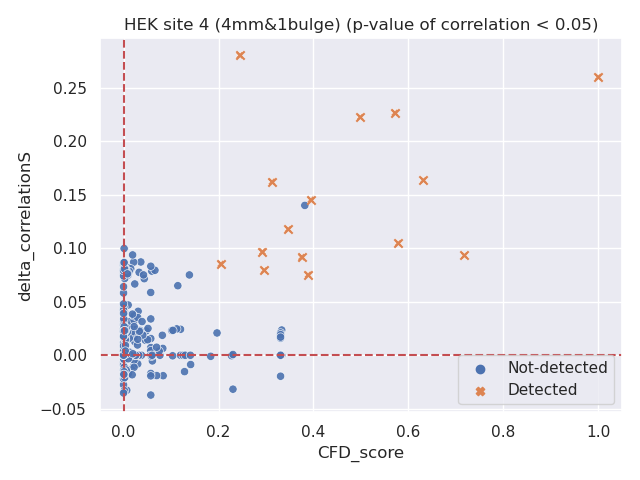

In [71]:
HEK4_df = pd.read_csv("./HEK4_test/HEK4.4mm.1gap.GOOD.dedup.targetsite.wgs.GUIDESeq.deOverlap.CFD.csv", index_col='target_name')
filtered_df = HEK4_df[HEK4_df['correlationS_pvalue_Treated']<0.05]
active_df = filtered_df[filtered_df['GUIDE-Seq'] == 'Detected']
edit_rate = filtered_df['CFD_score']
corr = filtered_df['delta_correlationS']
val = filtered_df['GUIDE-Seq']
ax = sns.scatterplot(x=edit_rate, y=corr, hue=val, style=val, alpha=0.9, style_order=['Not-detected', 'Detected'], hue_order=['Not-detected', 'Detected'])
plt.scatter(active_df['CFD_score'], active_df['delta_correlationS'], marker='x')
ax.axhline(0, ls='--', color='r')
ax.axvline(0, ls='--', color='r')
plt.title("HEK site 4 (4mm&1bulge) (p-value of correlation < 0.05)")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


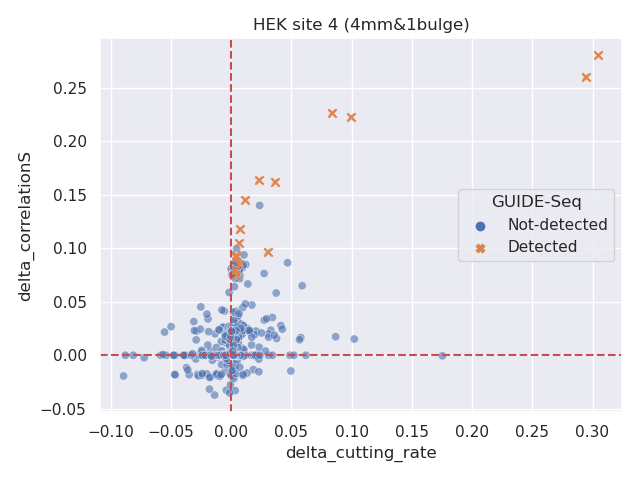

In [72]:
result_df = pd.read_csv("./HEK4_test/HEK4.4mm.1gap.GOOD.dedup.targetsite.wgs.GUIDESeq.deOverlap.CFD.csv", index_col='target_name')
valid_VEGFA3_df = result_df
filtered_df = valid_VEGFA3_df
filtered_df = HEK4_df[HEK4_df['correlationS_pvalue_Treated']<0.05]
active_df = filtered_df[filtered_df['GUIDE-Seq'] == 'Detected']
edit_rate = filtered_df['delta_cutting_rate']
corr = filtered_df['delta_correlationS']
val = filtered_df['GUIDE-Seq']
ax = sns.scatterplot(x=edit_rate, y=corr, hue=val, style=val, alpha=0.6,style_order=['Not-detected', 'Detected'], hue_order=['Not-detected', 'Detected'])
plt.scatter(active_df['delta_cutting_rate'], active_df['delta_correlationS'], marker='x')
ax.axhline(0, ls='--', color='r')
ax.axvline(0, ls='--', color='r')
plt.title("HEK site 4 (4mm&1bulge)")
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


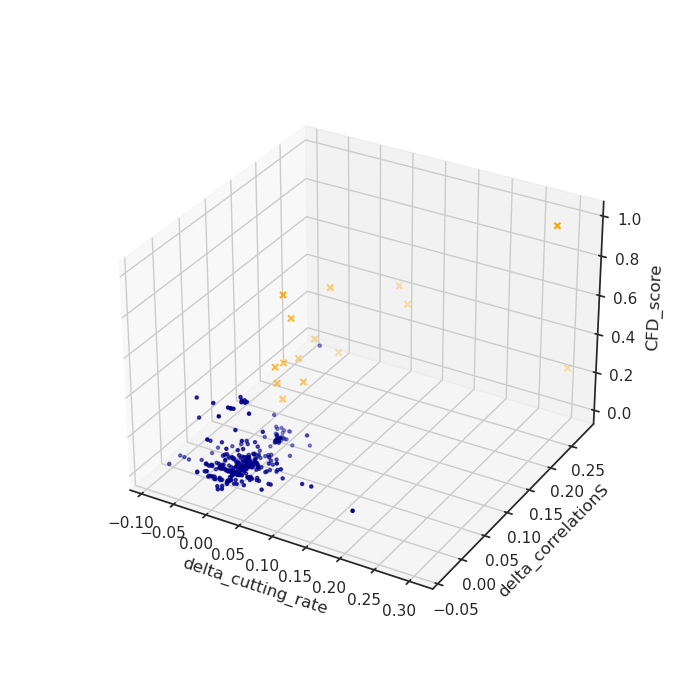

Text(0.5, 0, 'CFD_score')

In [92]:
sns.set_style('white')
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
inactive_df = filtered_df[filtered_df['GUIDE-Seq'] != 'Detected']
ax.scatter(active_df['delta_cutting_rate'], active_df['delta_correlationS'],active_df['CFD_score'], marker='x', color='orange')
ax.scatter(inactive_df['delta_cutting_rate'], inactive_df['delta_correlationS'],inactive_df['CFD_score'], marker='.', color='darkblue')
ax.set_xlabel("delta_cutting_rate")
ax.set_ylabel("delta_correlationS")
ax.set_zlabel("CFD_score")
# plt.tight_layout()

# Machine learning approach to classify target sites

In [223]:
result_df = pd.read_csv("./HEK4_test/HEK4.4mm.1gap.GOOD.dedup.targetsite.wgs.GUIDESeq.deOverlap.CFD.csv", index_col='target_name')
HEK4_df = result_df[['chr_id', 'bpstart', 'bpend', 'target_seq', 'n_reads', 'loc_info', 'correlationS_pvalue_Treated', 'CFD_score', 'delta_correlationS', 'delta_cutting_rate', 'GUIDE-Seq']]
HEK4_df = HEK4_df[HEK4_df['correlationS_pvalue_Treated']<0.05]

In [224]:
X = np.nan_to_num(HEK4_df[['CFD_score', 'delta_correlationS', 'delta_cutting_rate']].to_numpy())
y = np.array(HEK4_df['GUIDE-Seq'] == 'Detected').astype(int)

In [236]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm

In [226]:
X.shape, y.shape

((416, 3), (416,))

# Stratified Shuffle Validation

In [227]:
from sklearn.model_selection import StratifiedShuffleSplit

In [245]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=0)
yts = []
yps = []
for train_index, test_index in sss.split(X, y):
    # print("TRAIN:", len(train_index), "TEST:", len(test_index))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = RandomForestClassifier(random_state=66, n_jobs=30, verbose=0)
    # clf = svm.SVC(kernel='linear', C=1, probability=True)
    # clf = GradientBoostingClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, np.arange(2)[clf.classes_==1]]
    yts.append(y_test)
    yps.append(y_pred)
yts = np.concatenate(yts).squeeze()
yps = np.concatenate(yps).squeeze()

<IPython.core.display.Javascript object>


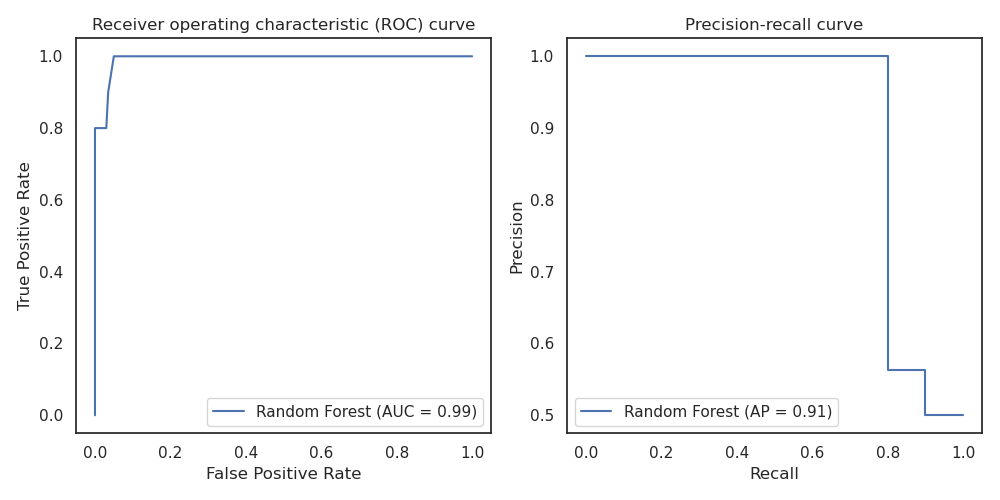

In [246]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score, roc_auc_score
sns.set_style('white')
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10,5))
fpr, tpr, _ = roc_curve(yts, yps, pos_label=1)
# print(roc_auc_score(y, HEK4_df['pred_proba']))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name='Random Forest', roc_auc=roc_auc_score(yts, yps)).plot(ax=ax)

prec, recall, _ = precision_recall_curve(yts, yps, pos_label=1)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall, estimator_name='Random Forest',average_precision=average_precision_score(yts, yps, pos_label=1)).plot(ax=ax1)

#ax1.legend(loc='upper right', facecolor='white')
ax1.set_title("Precision-recall curve")
# ax.legend(loc='lower right', facecolor='white')
ax.set_title("Receiver operating characteristic (ROC) curve")
plt.tight_layout()